In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm
from lightgbm import LGBMClassifier

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import warnings
warnings.simplefilter('ignore')

## read data 

client_train = pd.read_csv('data/client_train.csv')
invoice_train = pd.read_csv('data/invoice_train.csv')
client_test = pd.read_csv('data/client_test.csv')
invoice_test = pd.read_csv('data/invoice_test.csv')

In [24]:
## deal with categorical features

# 'month'
invoice_train['invoice_date'] = pd.to_datetime(invoice_train['invoice_date'])
invoice_train['month'] = invoice_train['invoice_date'].dt.month


In [25]:

# 'counter_statue'
invoice_train['counter_statue'] = invoice_train['counter_statue'].astype(str)
filtered_values = ['0', '1', '2', '3', '4', '5']
invoice_train = invoice_train[invoice_train['counter_statue'].isin(filtered_values)]

# 'client_id', 'counter_type', 'counter_number' -> 'counter_changed'

# offset comparison for Counter_number
invoice_train = invoice_train.sort_values(['client_id', 'counter_type', 'counter_number','invoice_date'])

invoice_train['counter_changed'] = np.where(
    (invoice_train['client_id'] == invoice_train['client_id'].shift(1)) &
    (invoice_train['counter_type'] == invoice_train['counter_type'].shift(1)) &
    (invoice_train['counter_number'] != invoice_train['counter_number'].shift(1)), 1, 0)

# 'tariif_type', 'reading_remarque', 

In [26]:

## deal with numerical features

# 'coeficient'

# 'months_number'
#invoice_train = invoice_train.query('months_number <= 24')

# 'old_index', 'new_index' -> 'consumption', 'consumption_ave'
# 'consommation_level_1','consommation_level_2', 'consommation_level_3', 'consommation_level_4'
# -> 'consommation_sum', 'consommation_ave', 'sonconsommation_not_consom', 'sonconsommation_less_0'

invoice_train['consumption'] = invoice_train['new_index'] - invoice_train['old_index']
invoice_train['consumption_ave'] = invoice_train['consumption'] / invoice_train['months_number']

invoice_train.eval('consommation_sum = consommation_level_1 + consommation_level_2 + consommation_level_3 + consommation_level_4', inplace=True)
invoice_train.eval('consommation_ave = consommation_sum / months_number', inplace=True)

invoice_train['consump_not_consom'] = np.where(invoice_train['consumption'] == invoice_train['consommation_sum'], 0, 1)
invoice_train['consump_less_0'] = np.where(invoice_train['consumption'] <= 0, 1, 0)



In [27]:
# all categorical features
#cat_features = ['month', 'counter_statue', 'tarif_type', 'reading_remarque', 'counter_type', 'counter_number']
cat_features = ['month', 'counter_statue', 'counter_type', 'counter_changed', 'consump_not_consom', 'consump_less_0']

In [28]:
new_cat_features = []

# one-hot encoding
for cat_feature in cat_features:
    encoder = OneHotEncoder()
    encoder.fit(invoice_train[cat_feature].values.reshape(-1, 1))
    tmp = encoder.transform(invoice_train[cat_feature].values.reshape(-1, 1)).toarray()
    new_columns = [(cat_feature + '_' + str(i)) for i in range(tmp.shape[1])]
    new_cat_features.extend(new_columns)
    tmp = pd.DataFrame(tmp, columns=new_columns)
    invoice_train = pd.concat([invoice_train, tmp], axis=1)
    invoice_train.drop(cat_feature, axis=1, inplace=True)

In [29]:

# aggregate features by client_id
def aggregate_by_client_id(invoice_data, cat_features):
    aggs = {
        #'consommation_level_1': ['min', 'max'], ## add max, min, sum?
        #'consommation_level_2': ['mean'],
        #'consommation_level_3': ['mean'],
        #'consommation_level_4': ['mean'],
        'consommation_sum': ['max', 'min', 'mean'],
        'consommation_ave': ['max', 'min', 'mean'],
        'months_number': ['max', 'min', 'mean'],
        'consumption': ['sum', 'max', 'min', 'mean'],
        'consumption_ave': ['max', 'min', 'mean']
    }

    for cat in cat_features:
        aggs[cat] = ['count'] # delete nunique

    agg_trans = invoice_data.groupby(['client_id']).agg(aggs)
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = invoice_data.groupby('client_id').size().reset_index(name='transactions_count')
    
    return pd.merge(df, agg_trans, on='client_id', how='left')


In [30]:
invoice_train_aggregated = aggregate_by_client_id(invoice_train, new_cat_features)

In [31]:
## how to combine it effectively? do EDV and decide whether to keep it
#invoice_train_aggregated = invoice_train_aggregated.eval('consommation_level_diff = cosommation_level_1_max - consommation_level_1_min', inplace=True)
#invoice_train_aggregated.drop(['consommation_level_1_max', 'consommation_level_1_min'], axis=1, inplace=True)

In [32]:
invoice_train_aggregated.head()

,client_id,transactions_count,consommation_sum_max,consommation_sum_min,consommation_sum_mean,consommation_ave_max,consommation_ave_min,consommation_ave_mean,months_number_max,months_number_min,...,counter_type_2_count,counter_changed_0_count,counter_changed_1_count,counter_changed_2_count,consump_not_consom_0_count,consump_not_consom_1_count,consump_not_consom_2_count,consump_less_0_0_count,consump_less_0_1_count,consump_less_0_2_count
0,train_Client_0,35,1386.0,38.0,362.971429,346.500000,19.0,82.503571,12.0,2.0,...,35,35,35,35,35,35,35,35,35,35
1,train_Client_1,37,1207.0,190.0,557.540541,194.000000,81.5,129.405405,8.0,2.0,...,37,37,37,37,37,37,37,37,37,37
2,train_Client_10,18,3082.0,188.0,836.500000,256.833333,47.0,126.972222,12.0,4.0,...,18,18,18,18,18,18,18,18,18,18
3,train_Client_100,20,15.0,0.0,1.200000,3.750000,0.0,0.300000,6.0,4.0,...,20,20,20,20,20,20,20,20,20,20
4,train_Client_1000,14,2382.0,124.0,922.642857,595.500000,62.0,237.910714,4.0,2.0,...,14,14,14,14,14,14,14,14,14,14


In [33]:
invoice_train_aggregated.columns

Index(['client_id', 'transactions_count', 'consommation_sum_max',
       'consommation_sum_min', 'consommation_sum_mean', 'consommation_ave_max',
       'consommation_ave_min', 'consommation_ave_mean', 'months_number_max',
       'months_number_min', 'months_number_mean', 'consumption_sum',
       'consumption_max', 'consumption_min', 'consumption_mean',
       'consumption_ave_max', 'consumption_ave_min', 'consumption_ave_mean',
       'month_0_count', 'month_1_count', 'month_2_count', 'month_3_count',
       'month_4_count', 'month_5_count', 'month_6_count', 'month_7_count',
       'month_8_count', 'month_9_count', 'month_10_count', 'month_11_count',
       'counter_statue_0_count', 'counter_statue_1_count',
       'counter_statue_2_count', 'counter_statue_3_count',
       'counter_statue_4_count', 'counter_statue_5_count',
       'counter_statue_6_count', 'counter_type_0_count',
       'counter_type_1_count', 'counter_type_2_count',
       'counter_changed_0_count', 'counter_changed

In [34]:
invoice_train_aggregated = invoice_train_aggregated.merge(client_train, on='client_id', how='left')

In [35]:
invoice_train_aggregated.columns

Index(['client_id', 'transactions_count', 'consommation_sum_max',
       'consommation_sum_min', 'consommation_sum_mean', 'consommation_ave_max',
       'consommation_ave_min', 'consommation_ave_mean', 'months_number_max',
       'months_number_min', 'months_number_mean', 'consumption_sum',
       'consumption_max', 'consumption_min', 'consumption_mean',
       'consumption_ave_max', 'consumption_ave_min', 'consumption_ave_mean',
       'month_0_count', 'month_1_count', 'month_2_count', 'month_3_count',
       'month_4_count', 'month_5_count', 'month_6_count', 'month_7_count',
       'month_8_count', 'month_9_count', 'month_10_count', 'month_11_count',
       'counter_statue_0_count', 'counter_statue_1_count',
       'counter_statue_2_count', 'counter_statue_3_count',
       'counter_statue_4_count', 'counter_statue_5_count',
       'counter_statue_6_count', 'counter_type_0_count',
       'counter_type_1_count', 'counter_type_2_count',
       'counter_changed_0_count', 'counter_changed

Client_train 裡 cat data 未處理one hot encoder
↓ hasn't been adjusted yet

In [36]:
columns_to_use = invoice_train_aggregated.columns.tolist()
columns_to_use = [col for col in columns_to_use if col not in ['client_id', 'client_catg', 'creation_date', 'target']]
#X_train = invoice_train_aggregated[columns_to_use]
#y_train = invoice_train_aggregated['target']

In [37]:
#X_train.shape, y_train.shape

In [38]:
X = invoice_train_aggregated[columns_to_use]
y = invoice_train_aggregated['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2019)

In [39]:
model = LGBMClassifier(boosting_type='gbdt', num_iterations=500)
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 6094, number of negative: 102298
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10144
[LightGBM] [Info] Number of data points in the train set: 108392, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.056222 -> initscore=-2.820585
[LightGBM] [Info] Start training from score -2.820585


LGBMClassifier(num_iterations=500)

In [40]:
train_pred = model.predict(X_train)
train_probs = model.predict_proba(X_train)[:, 1]

test_pred = model.predict(X_test)
test_probs = model.predict_proba(X_test)[:, 1]

## data for modelling, temporary ↓ 暫時

In [41]:
df = invoice_train_aggregated

In [42]:
df.to_csv('data/df.csv', index=False)

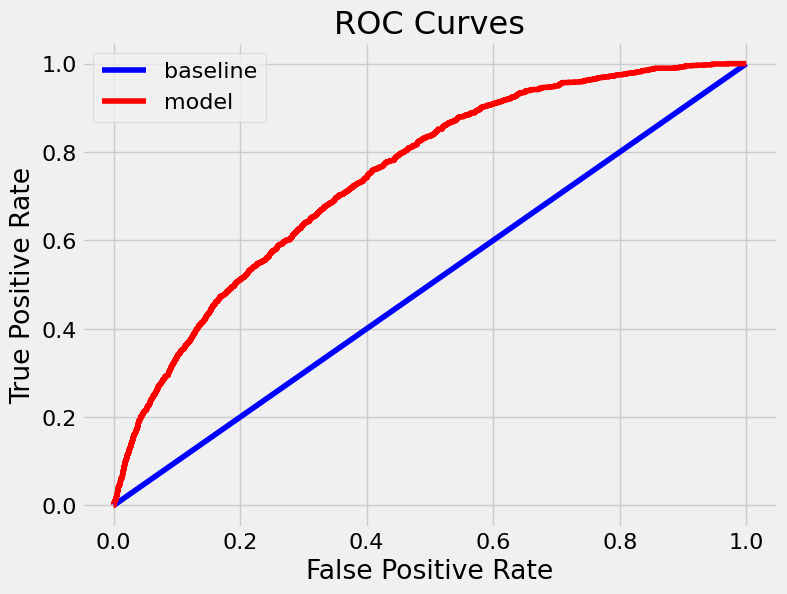

In [43]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve


# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

# Calculate false positive rates and true positive rates
base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
model_fpr, model_tpr, _ = roc_curve(y_test, test_probs)

plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
    
# Plot both curves
plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend()
plt.xlabel('False Positive Rate'); 
plt.ylabel('True Positive Rate'); plt.title('ROC Curves')
plt.show()



## test data ↓ 還沒改

In [ ]:
## deal with categorical features

# 'month'
invoice_train['invoice_date'] = pd.to_datetime(invoice_train['invoice_date'])
invoice_train['month'] = invoice_train['invoice_date'].dt.month


# 'counter_statue'
invoice_train['counter_statue'] = invoice_train['counter_statue'].astype(str)
filtered_values = ['0', '1', '2', '3', '4', '5']
invoice_train = invoice_train[invoice_train['counter_statue'].isin(filtered_values)]

# 'tariif_type', 'reading_remarque', 'counter_type', 'counter_number'


# all categorical features
#cat_features = ['month', 'counter_statue', 'tarif_type', 'reading_remarque', 'counter_type', 'counter_number']
cat_features = ['month', 'counter_statue', 'counter_type']

new_cat_features = []

# one-hot encoding
for cat_feature in cat_features:
    encoder = OneHotEncoder()
    encoder.fit(invoice_train[cat_feature].values.reshape(-1, 1))
    tmp = encoder.transform(invoice_train[cat_feature].values.reshape(-1, 1)).toarray()
    new_columns = [(cat_feature + '_' + str(i)) for i in range(tmp.shape[1])]
    new_cat_features.extend(new_columns)
    tmp = pd.DataFrame(tmp, columns=new_columns)
    invoice_train = pd.concat([invoice_train, tmp], axis=1)
    invoice_train.drop(cat_feature, axis=1, inplace=True)


## deal with numerical features

# 'coeficient'

# 'months_number'
invoice_train = invoice_train.query('months_number <= 24')

# 'old_index', 'new_index' -> 'consumption', 'consumption_ave'
invoice_train['consumption'] = invoice_train['new_index'] - invoice_train['old_index']
invoice_train['consumption_ave'] = invoice_train['consumption'] / invoice_train['months_number']
invoice_train = invoice_train.query('consumption >= 0')

# 'consommation_level_1','consommation_level_2', 'consommation_level_3', 'consommation_level_4'


# aggregate features by client_id
def aggregate_by_client_id(invoice_data, cat_features):
    aggs = {
        'consommation_level_1': ['mean'],
        'consommation_level_2': ['mean'],
        'consommation_level_3': ['mean'],
        'consommation_level_4': ['mean'],
        'months_number': ['max', 'min', 'mean'],
        'consumption': ['sum', 'max', 'min', 'mean'],
        'consumption_ave': ['max', 'min', 'mean']
    }

    for cat in cat_features:
        aggs[cat] = ['count', 'nunique'] 

    agg_trans = invoice_data.groupby(['client_id']).agg(aggs)
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = invoice_data.groupby('client_id').size().reset_index(name='transactions_count')
    
    return pd.merge(df, agg_trans, on='client_id', how='left')

invoice_train_aggregated = aggregate_by_client_id(invoice_train, new_cat_features)

invoice_train_aggregated = invoice_train_aggregated.merge(client_train, on='client_id', how='left')

columns_to_use = invoice_train_aggregated.columns.tolist()
columns_to_use = [col for col in columns_to_use if col not in ['client_id', 'client_catg', 'creation_date', 'target']]
X_train = invoice_train_aggregated[columns_to_use]
y_train = invoice_train_aggregated['target']

baseline_model = LGBMClassifier(boosting_type='gbdt', num_iterationss=500)
baseline_model.fit(X_train, y_train)
